<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA0_7x_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA 0.7x
### Notes:

### 0.70
##### **SA argorithm**: Fast stochastic optimization algorithm by adamW and sparse-matrix is now available.
##### **Parameter optimization function** By running *Findbp* function, the optimization parameters realizing fast convergence and nearly fittest results can be preliminary screened.   

## Setup

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
rm: cannot remove 'rELA': No such file or directory
Cloning into 'rELA'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 934 (delta 155), reused 114 (delta 114), pack-reused 764 (from 2)
Receiving objects: 100% (934/934), 9.74 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (460/460), done.


In [ ]:
%%R
# [for Google Colab]
# from v0.50, Due to errors in installing igraph and tidygraph
#system("add-apt-repository -y ppa:marutter/rrutter4.0")
#system("add-apt-repository -y ppa:c2d4u.team/c2d4u4.0+")
#system("add-apt-repository ppa:cran/v8")
#system("apt-get update")
#system("apt-get install libnode-dev")
#system("apt-get install r-cran-igraph r-cran-tidygraph")

NULL


In [ ]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('dplyr')
install.packages('tidyr')
install.packages('ggplot2')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
install.packages("devtools")
library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('dplyr')
library('tidyr')
library('ggplot2')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")
library("devtools")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
%%R
# If already installed
detach("package:rELA",unload=TRUE)
remove.packages("rELA")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving rELA.v0.701.tar.gz to rELA.v0.701.tar.gz


In [ ]:
%%R
install_local("/content/rELA.v0.701.tar.gz",type="source")

# optional: install rELA package
# install.packages("/content/rELA.v0.70.tar.gz",type = "source")

library("rELA")

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpRa900p/remotes14d45e24820/rELAv0.70/DESCRIPTION’ ... OK
* preparing ‘rELA’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* installing the package to process help pages
* saving partial Rd database
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rELA_1.0.tar.gz’



## Energy Landscape Analysis

### Download data

In [ ]:
%%R
# Specify the path for your own data in the code below, if necessary.
baseabtable <- read.csv('/content/drive/MyDrive/Colab Notebooks/ela_data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('/content/drive/MyDrive/Colab Notebooks/ela_data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [ ]:
%%R
head(basemetadata, 7)

         factor.1   factor.2
sample.1    -0.92 2.79692115
sample.2     0.34 2.14701252
sample.3    -0.92 1.60611363
sample.4    -0.24 0.58476465
sample.5     0.40 1.73161379
sample.6    -0.82 2.95971753
sample.7     0.36 0.07787331


In [ ]:
%%R
# To group species with the same presence/absence pattern into one group,
#set grouping to 1 and specify a number between 0 and 1 for grouping_th.
# If 0, only species with the same presence/absence pattern will be grouped together.
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata=NULL, normalize=1, parameters=c(0.01, 0.01, 0.99), grouping=1, grouping_th=0.)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


### Parameter fitting

In [ ]:
%%R
list[bp,allresults] <-Findbp(ocmat,rep=16,threads=2,fastfitting = TRUE)

Try: lambda=0.001000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.100000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.200000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.250000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.400000, we=0.001000, runadamW=TRUE, Sparse=TRUE



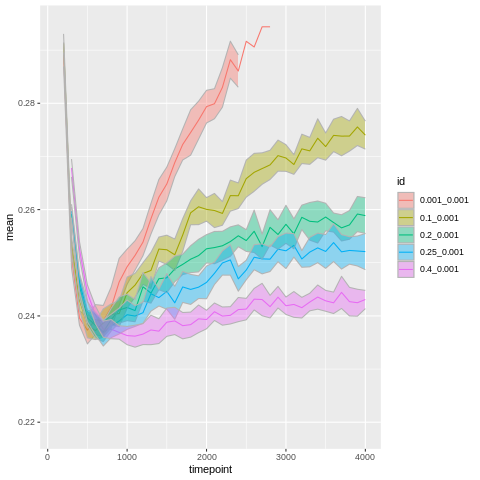

In [ ]:
%%R
plotSAtest(allresults)

Here, "id" corresponds to the tested parameter sets (lambda, we), which are key hyper parameters for Sparse matrix and adamW. The results explain lambda should be set to high for preventing overfitting in the optimization.

In [ ]:
%%R
# Then use the parameter set giving the best fitted result
list[lmd,we,totalit] <- as.numeric(unlist(strsplit(names(bp)[1], split = "_")))
#runSA: ocmatrix, env (environmental parameters; with>SA / without>fullSA), qth (threshold for stopping computation), rep (number of fitting processes to compute mean parameter value), threads (number of parallel threads)
sa <- runSA(ocmat, rep = 16,threads=2,getall=FALSE,totalit=totalit,
            lambda = lmd, we = we)


Start parameter fitting:
SA: elapsed time 10.55 sec



In [ ]:
%%R
list[he,je,ge,hge] <- sa2params(sa)

In [ ]:
%%R
he

 species.12  species.16   species.7   species.5   species.2  species.10 
-2.37278935 -2.23216263 -2.23216263 -1.99096281 -1.81915844 -1.21576738 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.67575544 -3.02042489 -2.47653840  0.39256170  1.35271807  1.37663245 
  species.3  species.13   species.1   species.9 
 0.52324814 -0.09309042  2.47653840  2.47653840 


### Analysis and visualization of energy landscape
#### ELA function

In [ ]:
%%R
ela <- ELA(sa, env=NULL,
                SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
                threads=2, reporting=TRUE)

Start ELA:
5 stable states were found.
Checking 10 tipping points.
converting...
ELA: elapsed time 0.99 sec


In [ ]:
%%R
elap <- ELPruning(ela, th=0.2)

Start pruning:
*.....
ELPruning: elapsed time 0.31 sec


*ATTENTION*  
The return value of ELPruning is a list consisting of two elements, the first of which takes the same form as ELA, and the second of which indicates the correspondence between the stable states before and after pruning.

In [ ]:
%%R
list[stablestates, stablen, tippingpoints, tippingen] <- elap[[1]]

Stable states

In [ ]:
%%R
stablestates

[1] "09x" "EWB"


Convert an integer representing a stable state (ssid) to a binary vector

In [ ]:
%%R
# ssid -> binary vector
bin = as.list(lapply(stablestates, function(x){id2bin(x, ncol(ocmat))}))
names(bin) <- stablestates
bin

$`09x`
 [1] 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1

$EWB
 [1] 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1



Convert a binary vector to a ssid

In [ ]:
%%R
# binary vector -> ssid
as.vector(sapply(bin, bin2id))

[1] "09x" "EWB"


Table of SSID, Energy, Community composition

In [ ]:
%%R
sstable(elap[[1]]) # or sstable(ela)

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -13.9827382205308          0          0         0         0         0
2 EWB -12.0374678973876          1          1         1         0         1
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
2          0         0          0          0         0         0          0
  species.3 species.13 species.1 species.9
1         1          0         1         1
2         1          0         1         1


Export the table to Google Drive in CSV format

In [ ]:
%%R
write.csv(x = sstable, file="drive/MyDrive/colab_export/sstable.csv") # "sstable.csv" is saved in "colab_export" folder of your Google Drive.

ID and energy of tipping points

Table of TPID, SSID1, SSID2, Energy, Community composition

In [ ]:
%%R
tptable(elap[[1]])

   TP SS1 SS2            Energy species.12 species.16 species.7 species.5
1 4eB EWB 09x -7.62736902156771          0          1         0         0
  species.2 species.10 species.8 species.11 species.15 species.6 species.4
1         1          0         1          0          0         0         0
  species.14 species.3 species.13 species.1 species.9
1          0         1          0         1         1


Energy of any community composition


In [ ]:
%%R
cEnergy(ocmat[1,], he, je)

[1] -3.02034


Find the stable state for a community composition

In [ ]:
%%R
Bi(ocmat[1,], he, je)

[[1]]
[1] "01t"

[[2]]
[1] -11.64071



### Principal component analysis  
Observed community compositions plotted on a PC1,2 plane and color-coded by their stable states

NULL


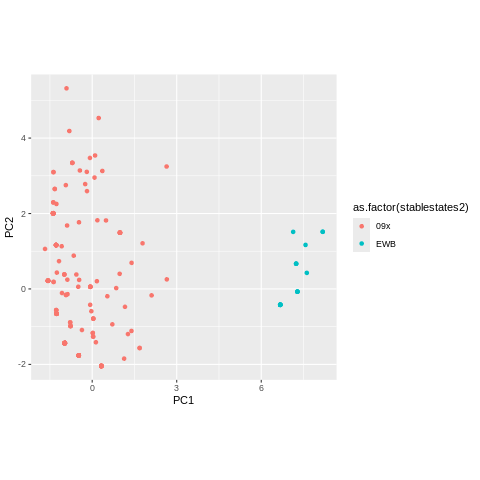

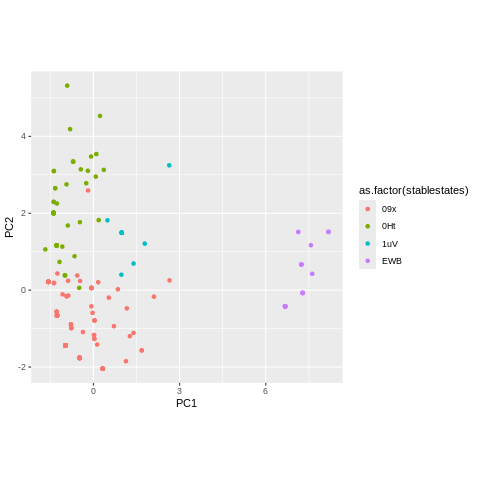

In [ ]:
%%R
PCplot(ocmat, sa, ssrep=elap[[2]])
PCplot(ocmat, sa, ssrep=elap[[2]], pruned=FALSE)

Disconnectivity graph


NULL


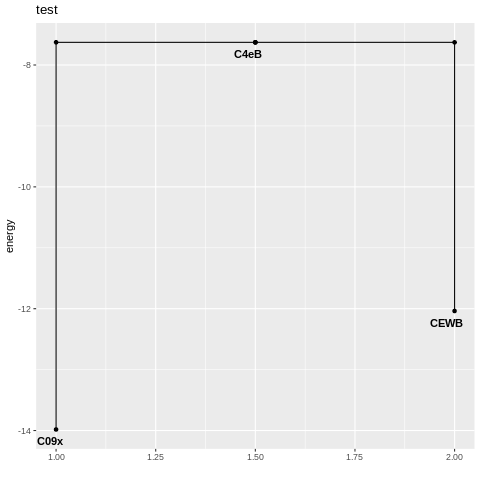

In [ ]:
%%R
showDG(elap[[1]], ocmat, "test")

### Visualization of species' interaction

NULL


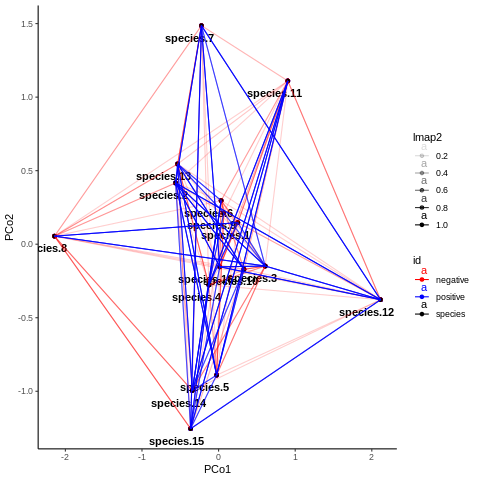

In [ ]:
%%R
showIntrGraph(elap[[1]], sa, th=0.01, # <- Threshold for links to be displayed
              annot_adj=c(0.75, 2.00))

### Energy landscape analysis with environmental gradients

In [ ]:
# Formatting with metadata
%%R
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata=basemetadata, normalize=1, parameters=c(0.01, 0.01, 0.99), grouping=1, grouping_th=0.)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


In [ ]:
%%R
list[bp,allresults] <- Findbp(ocmat,enmat=enmat,rep=16,threads=2,fastfitting = TRUE)

Try: lambda=0.001000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.100000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.200000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.250000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.400000, we=0.001000, runadamW=TRUE, Sparse=TRUE



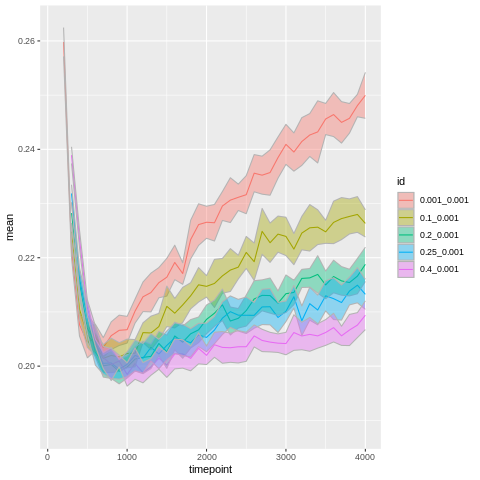

In [ ]:
%%R
plotSAtest(allresults)

In [ ]:
%%R
# Then use the parameter set giving the best fitted result
list[lmd,we,totalit] <- as.numeric(unlist(strsplit(names(bp)[1], split = "_")))
#runSA: ocmatrix, env (environmental parameters; with>SA / without>fullSA), qth (threshold for stopping computation), rep (number of fitting processes to compute mean parameter value), threads (number of parallel threads)
sa <- runSA(ocmat, enmat=enmat, rep = 16,threads=2, getall=FALSE, totalit=totalit,
            lambda = lmd, we = we)


Start parameter fitting
SA: elapsed time 9.51 sec



In [ ]:
%%R
gela <- GradELA(sa=sa, eid="factor.1", # Specify the label or position of an environmental factor
  enmat=enmat, env=NULL, range=NULL, steps=32, th=0.05, threads=2) #[[1]]: return value of ELA function for each step, [[2]]: value of environmental factor for each step, [[3]]: specified environmental factor

env not specified, the mean of enmat is used
processing(32) |================================|
Elapsed time 32.23 sec


NULL


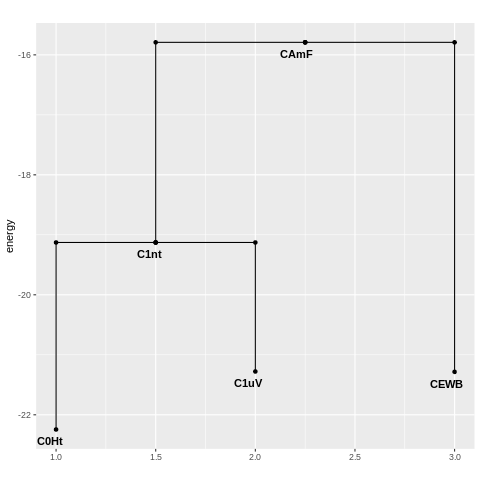

In [ ]:
# Disconnectivity graph
%%R
showDG(gela[[1]][[1]][[1]], ocmat)

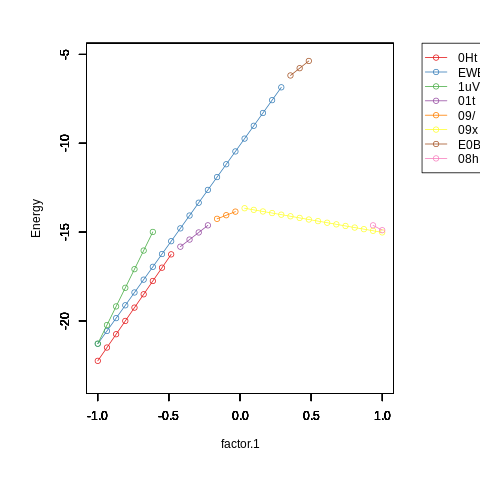

In [ ]:
# Stable state diagram
%%R
showSSD(gela)

In [ ]:
%%R
gstates <- foreach(x=gela[[1]], .combine='c') %do% {
    x[[1]][[1]]}
unique(gstates)

[1] "0Ht" "EWB" "1uV" "01t" "09/" "09x" "E0B" "08h"


#### GradELA 3D plot

In [ ]:
%%R
gelsobj <- GELSObj(gela, sa, threads=2)

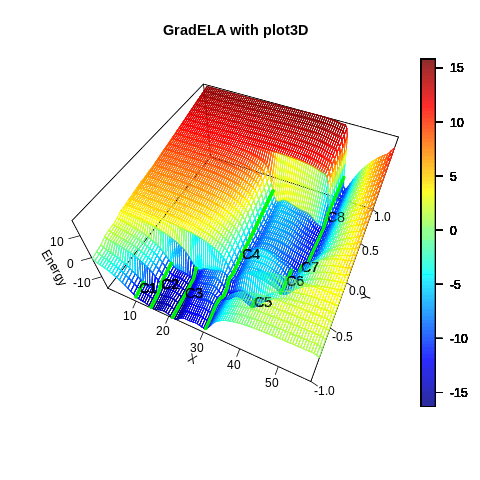

In [ ]:
%%R
showGELA3D(gelsobj)

## Stability

In [ ]:
%%R
stb <- Stability(sa, ocmat, enmat=NULL, threads=2)
head(stb, 5)

Start Stability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
Stability: elapsed time 10.11 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1   10.4106448  0.0000000  -3.472982 -13.88363      07/             09x
sample.10   1.5193531  0.5628978 -12.364273 -13.88363      08/             09x
sample.100  7.4326828  0.0000000  -6.450944 -13.88363      1uF             09x
sample.101  0.6939698  0.0000000 -13.189657 -13.88363      09t             09x
sample.102  0.9926962  0.3696444 -12.890930 -13.88363      01t             09x


In [ ]:
%%R
stbwe <- Stability(sa, ocmat, enmat=enmat, threads=2)
head(stbwe, 5)

Start Stability:
Stability: elapsed time 31.09 sec

           energy.gap ss.entropy e.realize  e.stable state.id stable.state.id
sample.1    8.3707834  0.3314018 -13.02003 -21.39081      07/             0Ht
sample.10   2.3483800  0.0000000 -11.79157 -14.13995      08/             09x
sample.100  1.5014344  0.9942026 -19.28339 -20.78483      1uF             1uV
sample.101  0.4611839  0.9964625 -14.82135 -15.28253      09t             01t
sample.102  0.1606606  0.4594130 -15.99785 -16.15852      01t             0Ht


gStability returns a list of 4 elements: the first two are the dataframe for pruned/non-pruned energy landscape, respectively. In addition to the dataframe of Stability it includes e.tipping (energy of tipping point) and energy.barrier (height of energy from observed state to the tipping point).The third output is a list of parameters (h, g, j, h+g*env) and a summary table of stable states, and the fourth output is a list encapsulating the inputs required for the various plots.  
  
output of gStability:  
[[1]]: data.frame(energy.gap, ss.entropy, energy.barrier, e.realize, e.stable, e.tipping, state.id, stable.state.id)  
[[2]]: data.frame(energy.gap.np, ss.entropy.np, energy.barrier.np, e.realize, e.stable.np, e.tipping.np, state.id.np, stable.state.id.np)  
[[3]]: w/ enmat: list(list(list(he, je, ge, hge), data.frame(sstable)), ...); w/o enmat: list(list(he, je, ge, hge), data.frame(sstable))  
[[4]]: w/ enmat: list(list(ocmat, env, sa, ela, elanp), ...); w/o enmat: list(ocmat, env, sa, ela, elanp)

In [ ]:
%%R
gstb <- gStability(sa, ocmat, enmat=NULL, threads=2)

Start gStability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
gStability: elapsed time 21.70 sec



In [ ]:
%%R
gstb[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable e.tipping
sample.1   10.4106448  0.0000000       6.519768  -3.472982 -13.88363 -7.363859
sample.10   1.5193531  0.0000000       6.519768 -12.364273 -13.88363 -7.363859
sample.100  7.4326828  0.0000000       6.519768  -6.450944 -13.88363 -7.363859
sample.101  0.6939698  0.6712479       6.519768 -13.189657 -13.88363 -7.363859
sample.102  0.9926962  0.0000000       6.519768 -12.890930 -13.88363 -7.363859
sample.103  3.3292191  0.0000000       6.519768 -10.554407 -13.88363 -7.363859
sample.104  0.3535122  0.0000000       6.519768 -13.530114 -13.88363 -7.363859
sample.105  3.2469987  0.2422922       3.136596  -7.253456 -10.50045 -7.363859
           state.id stable.state.id
sample.1        07/             09x
sample.10       08/             09x
sample.100      1uF             09x
sample.101      09t             09x
sample.102      01t             09x
sample.103      0Ht             09x
sample.104      09/             09x
s

In [ ]:
%%R
gstb[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1      10.4106448     0.0000000          6.519768  -3.472982   -13.88363
sample.10      1.5193531     0.0000000          6.519768 -12.364273   -13.88363
sample.100     7.4326828     0.1791163          6.519768  -6.450944   -13.88363
sample.101     0.6939698     0.0000000          6.519768 -13.189657   -13.88363
sample.102     0.9926962     0.8048765          6.519768 -12.890930   -13.88363
sample.103     3.3292191     0.0000000          6.519768 -10.554407   -13.88363
sample.104     0.3535122     0.9483407          6.519768 -13.530114   -13.88363
sample.105     3.2469987     0.1633455          3.136596  -7.253456   -10.50045
           e.tipping.np state.id.np stable.state.id.np
sample.1      -7.363859         07/                09x
sample.10     -7.363859         08/                09x
sample.100    -7.363859         1uF                09x
sample.101    -7.363859         09t                09x
sampl

In [ ]:
%%R
gstbe <- gStability(sa, ocmat, enmat=enmat, th=0.2, threads=2)

Start gStability:
gStability: elapsed time 179.31 sec



In [ ]:
%%R
gstbe[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable  e.tipping
sample.1    8.3707834  0.0000000       7.145551 -13.020031 -21.39081 -14.245263
sample.10   2.3483800  0.0000000            Inf -11.791567 -14.13995        Inf
sample.100  1.5014344  0.9992612       2.525199 -19.283391 -20.78483 -18.259626
sample.101  0.4611839  0.6098403       8.706321 -14.821351 -15.28253  -6.576214
sample.102  0.1606606  0.9189611       7.943932 -15.997855 -16.15852  -8.214584
sample.103  0.0000000  0.0000000       8.383460 -19.221923 -19.22192 -10.838463
sample.104  0.2330333  0.0000000            Inf -13.407321 -13.64035        Inf
sample.105  1.7110668  0.2513881       1.668724  -8.366788 -10.07785  -8.409131
           state.id stable.state.id
sample.1        07/             0Ht
sample.10       08/             09x
sample.100      1uF             1uV
sample.101      09t             01t
sample.102      01t             0Ht
sample.103      0Ht             0Ht
sample.104      09/         

===================================================================================

NULL


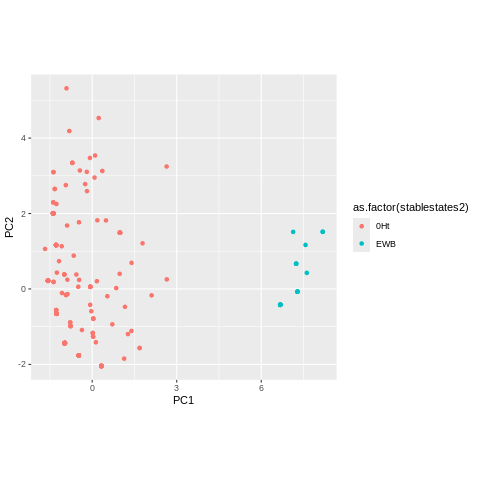

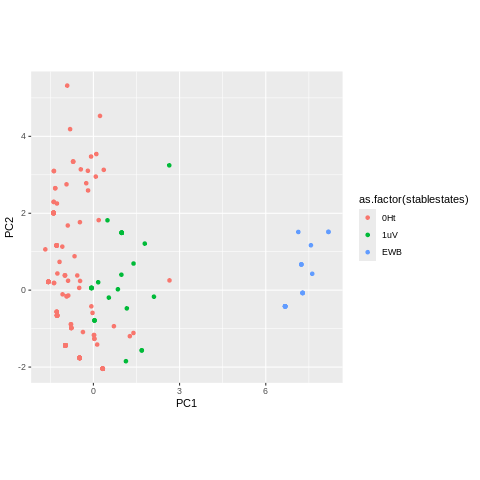

In [ ]:
## PCplot
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
env <- gstbe[[4]][[sample.id]][[2]]
sa <- gstbe[[4]][[sample.id]][[3]]
ela <- gstbe[[4]][[sample.id]][[4]]
# if enmat=NULL, remove "[[sample.id]]"

PCplot(ocmat, sa, env, ssrep=ela[[2]])
PCplot(ocmat, sa, env, ssrep=ela[[2]], pruned=FALSE)

NULL


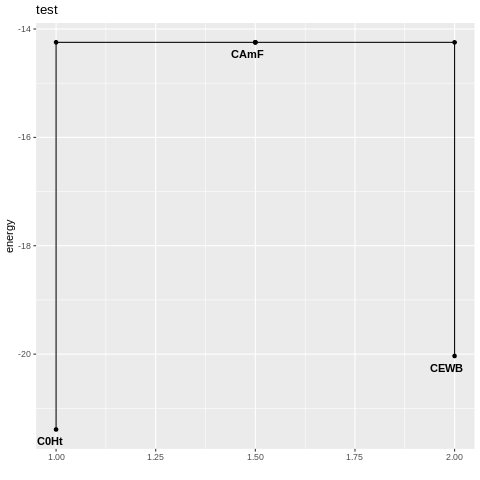

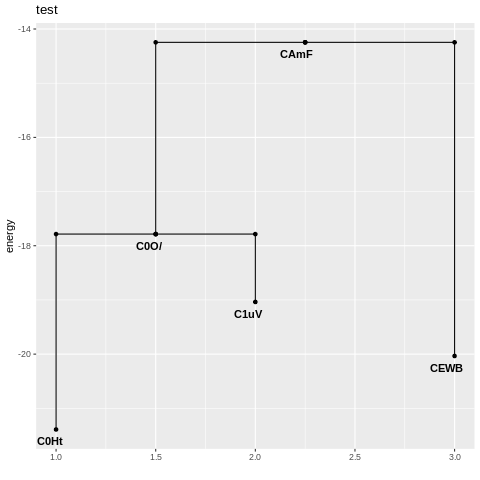

In [ ]:
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
ela <- gstbe[[4]][[sample.id]][[4]]
elanp <- gstbe[[4]][[sample.id]][[5]]
# if enmat=NULL, remove "[[sample.id]]"

showDG(ela[[1]], ocmat, "test")
showDG(elanp, ocmat, "test")